In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

We are preprocessing our data, we have taken the first 4000 and last 4000 tweets from the dataset training a BERT model for 1.6 million tweets was a computational challenge and did not allow us time for experimentation or further fine tuning.

We have taken 6 columns, sentiment, id, date, query, user and tweet. As we only need sentiment and tweet mainly, we drop the remaining column data to improve overall data processing speed of the model.

In [91]:
df1=df.iloc[:1000]
df2=df.iloc[995000:1000000]
df3=pd.concat([df1,df2], ignore_index=True)
df3

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
5995,4,"@healingsinger thank you, i needed that"
5996,4,@vactress http://bit.ly/cADea Maybe this is m...
5997,4,"@Brat13 Hell, Windows 7 will be out of my pric..."
5998,4,@jigardoshi neah.. i wish! just reminiscing r...


<Axes: ylabel='count'>

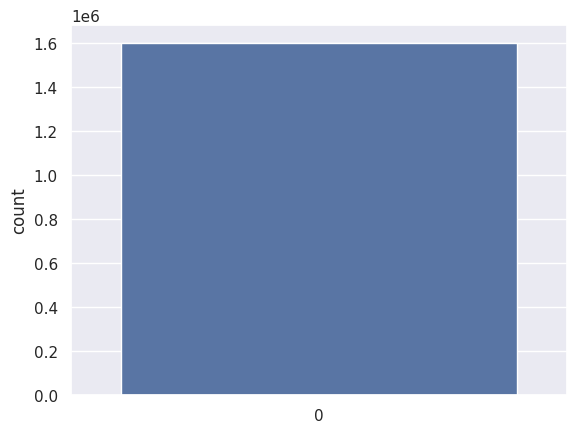

In [92]:
sns.countplot(df.Sentiment)

In [93]:
df3['Sentiment'] = df3.Sentiment.replace(4,1)

<Axes: ylabel='count'>

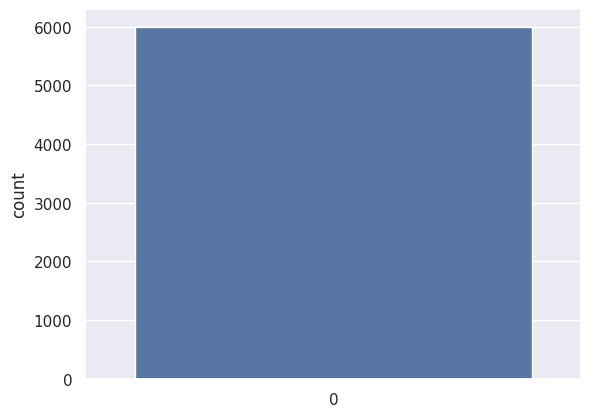

In [94]:
sns.countplot(df3.Sentiment)

In [95]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [96]:
df3['Tweet'] = df3.Tweet.apply(process_text)

In [98]:
df3.tail()

,Sentiment,Tweet
5995,1,"entity thank you, i needed that"
5996,1,entity maybe this is more you
5997,1,"entity hell, windows 7 will be out of my price..."
5998,1,entity neah.. i wish! just reminiscing read t...
5999,1,entity ...and by the way: i rewatched sun godd...


In [99]:
labels = df3.Sentiment.values
text = df3.Tweet.values

As can seen above, I have preprocessed the dataset differently for BERT since it's requirements for model training slighlty differ from LSTM. We have removed all the tokens, stop words, urls and and such.

In [100]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
from torch.optim import SGD

We are initializing a pretrained BERT model. BERT model

---

performance is accurate and very resourceful since it is already pretrained on a large dataset and thus, it is used to capturing even contextual cues such as "I am not great" to mean a negative emotion.

We are training our model using 2 optimizers, AdamW and SGD. We have trained it with 2 different learning rates, 0.002 and 2e-8, for 10 and 20 epochs respectively and observed the overall results of the model.

In [101]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [102]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [103]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [104]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  4800
Validation Size -  1200


In [105]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)

In [106]:
len(train_dl),len(val_dl)

(150, 38)

In [107]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [110]:
optimizer = AdamW(model.parameters(),lr = 0.00002,eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [111]:
from transformers import get_linear_schedule_with_warmup
epochs = 10
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [112]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [113]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [122]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
epochs=20
for epoch in tqdm(range(1, epochs)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1374260580042998
Validation loss: 0.3716785452867809
Accuracy: 0.8766666666666667


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.07522771293918291
Validation loss: 0.4766351112017506
Accuracy: 0.89


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.04592496161659559
Validation loss: 0.5203873544539276
Accuracy: 0.8833333333333333


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.031892808029272905
Validation loss: 0.57210402778889
Accuracy: 0.8816666666666667


Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.01944664552070511
Validation loss: 0.6614371722466067
Accuracy: 0.8758333333333334


Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.01143879264437904
Validation loss: 0.7127286199676363
Accuracy: 0.8783333333333333


Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.009118769391595076
Validation loss: 0.7462327782260744
Accuracy: 0.8775


Epoch 8:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0060171338886721056
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 9:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0060824220835153636
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 10:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.005957681373499024
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 11:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0052198023155021174
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 12:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.007060186336748302
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 13:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.005593020335848754
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 14:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.00554131623939611
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 15:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.005741049500453906
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 16:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.006087712045215691
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 17:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.005815572089632042
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 18:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.004846248542889953
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


Epoch 19:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.005109365380679568
Validation loss: 0.7410039419406339
Accuracy: 0.8783333333333333


In [115]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [116]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [117]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [118]:
ans = Sentiment('This is great')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [119]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Positive


In [120]:
ans = Sentiment('This is not great')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [121]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative


We can see that, BERT is capable of understanding and classifying statements with contextual cues like "This is not great" is a negative emotion.

In [123]:
optimizer = AdamW(model.parameters(),lr = 0.00002, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=2,
                                           num_training_steps=total_steps)

In [124]:
epochs=20
for epoch in tqdm(range(1, epochs)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    tqdm.write(f'Optimizer: {optimizer}')



  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.027734553767950275
Validation loss: 0.7279708393310246
Accuracy: 0.8741666666666666
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 1.8024032042723633e-05
    weight_decay: 0.0
)


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.03030258763503904
Validation loss: 0.8275036223624882
Accuracy: 0.8741666666666666
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 1.602136181575434e-05
    weight_decay: 0.0
)


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.01806643400375227
Validation loss: 0.8441877333741439
Accuracy: 0.8833333333333333
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 1.4018691588785047e-05
    weight_decay: 0.0
)


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.010748615498838869
Validation loss: 0.8533370440494955
Accuracy: 0.89
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 1.2016021361815755e-05
    weight_decay: 0.0
)


Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.010579630945115544
Validation loss: 0.9276267148517562
Accuracy: 0.8858333333333334
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 1.0013351134846463e-05
    weight_decay: 0.0
)


Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.003671017878926553
Validation loss: 0.9487831090625963
Accuracy: 0.8883333333333333
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 8.01068090787717e-06
    weight_decay: 0.0
)


Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.004392274068377447
Validation loss: 0.9437385542612327
Accuracy: 0.8908333333333334
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 6.0080106809078775e-06
    weight_decay: 0.0
)


Epoch 8:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0018334041699563386
Validation loss: 0.9675563652264444
Accuracy: 0.8908333333333334
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 4.005340453938585e-06
    weight_decay: 0.0
)


Epoch 9:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0014725376648614958
Validation loss: 0.980198671943263
Accuracy: 0.8916666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 2.0026702269692925e-06
    weight_decay: 0.0
)


Epoch 10:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0026169622464779726
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 11:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0012604583524080226
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 12:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0033821245357588243
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 13:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0014914634295443345
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 14:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.003993091110508734
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 15:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0013455541174092409
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 16:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.0013503683590412644
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 17:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.005423118037494229
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 18:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.0012392478782082131
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


Epoch 19:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.0013531418467391631
Validation loss: 0.9843608470339524
Accuracy: 0.8891666666666667
Optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
)


In [125]:
optimizer = SGD(model.parameters(),lr = 0.0002,momentum=1e-8)

In [126]:
epochs=20
for epoch in tqdm(range(1, epochs)):

    model.train()

    loss_train_total = 1

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    tqdm.write(f'Optimizer: {optimizer}')



  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.007827115999292195
Validation loss: 0.9846131182030627
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.009556451350714876
Validation loss: 0.9845452191014039
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.00795585688574647
Validation loss: 0.9846202033130746
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.008083867275308876
Validation loss: 0.9848537123516986
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.008090756097893366
Validation loss: 0.984804339314762
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.007899425951145532
Validation loss: 0.9848928647605997
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.009050835790185374
Validation loss: 0.985036944088183
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 8:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.007967539997565231
Validation loss: 0.9850596973770543
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 9:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.008093002408556154
Validation loss: 0.9853184387872094
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 10:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.008284719268000723
Validation loss: 0.9853483948268389
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 11:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.00890674505764764
Validation loss: 0.9854319487747393
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 12:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.00984310195640622
Validation loss: 0.985462727515321
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 13:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.008471620558811992
Validation loss: 0.9854530252908406
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 14:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.007755458827632538
Validation loss: 0.9855845845059344
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 15:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.00871229566285668
Validation loss: 0.9856568072971544
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 16:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.009213227556501806
Validation loss: 0.9856872511537451
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 17:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.008250691648960735
Validation loss: 0.9858246782892629
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 18:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.008547887717577396
Validation loss: 0.9856747733919244
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 19:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.007942891828182232
Validation loss: 0.9857974272025259
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


In [127]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [128]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [129]:
ans = Sentiment('i am sad')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [130]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [131]:
optimizer = SGD(model.parameters(),lr = 0.002,momentum=1e-8)

In [132]:
epochs=30
for epoch in tqdm(range(1, epochs)):

    model.train()

    loss_train_total = 1

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    tqdm.write(f'Optimizer: {optimizer}')



  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.007915023442146776
Validation loss: 0.9871784856444911
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.009677656213013202
Validation loss: 0.9872853528512152
Accuracy: 0.8883333333333333
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0076256211639823355
Validation loss: 0.9870315523524034
Accuracy: 0.8883333333333333
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.010105669641270652
Validation loss: 0.9862928633627138
Accuracy: 0.8841666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.009383707926353964
Validation loss: 0.985435487408387
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.009725247890407141
Validation loss: 0.9858483656456596
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.010026508217100247
Validation loss: 0.987442567160255
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 8:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.009175181218330787
Validation loss: 0.9850376977732307
Accuracy: 0.89
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 9:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.00808625210327591
Validation loss: 0.9861174327762503
Accuracy: 0.89
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 10:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00816603144701124
Validation loss: 0.9877256931442964
Accuracy: 0.8891666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 11:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.00801785491836199
Validation loss: 0.9876545730390047
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 12:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.008069869023978148
Validation loss: 0.9911678111866901
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 13:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.008738248563507417
Validation loss: 0.9936511312660418
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 14:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.008345911489401866
Validation loss: 0.9936683538712954
Accuracy: 0.8841666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 15:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.007949564603040925
Validation loss: 0.9936614216942536
Accuracy: 0.8841666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 16:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.008076522653257902
Validation loss: 0.9962836990230962
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 17:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.007998917816573036
Validation loss: 0.9932279053487276
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 18:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.007992382514906542
Validation loss: 0.9930193706562644
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 19:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.00804434526894814
Validation loss: 0.9968662387446353
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 20:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.0076392775965481025
Validation loss: 0.9979470387885445
Accuracy: 0.885
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 21:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.008165414340292046
Validation loss: 0.9987202506316336
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 22:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.00858377480947335
Validation loss: 0.9975060491185439
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 23:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.007745548811532596
Validation loss: 0.9979441769813236
Accuracy: 0.8866666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 24:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.008938854449734208
Validation loss: 0.9961522221565247
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 25:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.007836401982240204
Validation loss: 0.9968048906640002
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 26:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.00807886540216714
Validation loss: 0.9971506415229094
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 27:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.007734259875505813
Validation loss: 1.0018001755601482
Accuracy: 0.8866666666666667
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 28:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.008014958470715403
Validation loss: 1.0026940648493015
Accuracy: 0.8875
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


Epoch 29:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.007752035792315534
Validation loss: 1.001206743874048
Accuracy: 0.8858333333333334
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 1e-08
    nesterov: False
    weight_decay: 0
)


In our BERT sentiment analysis implementation, we conducted experiments using both AdamW and SGD optimizers, each trained for 20 epochs, with a pre-trained BERT model. Despite the relatively modest dataset size of 6000 tweets, our findings showcase promising results. The AdamW optimizer demonstrated slightly superior performance compared to SGD, achieving an accuracy of 88.9% with a loss of 0.137. These metrics were pivotal in assessing the model's overall performance.

In [133]:
ans = Sentiment('i am not sad')
if ans == 1:
    print("Positive")
else:
    print("Negative")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Positive


In [134]:
ans = Sentiment('i am sad')
if ans == 1:
    print("Positive")
else:
    print("Negative")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Negative


We can see that the model is able to understand contextual information through this classification test. I am not sad is considered a positive emotion while I am sad is considered a negative emotion. Thus, it is a decent model with good accuracy and good classification.